# Лабораторная работа №1

## Часть 1. Выполнил Филенков Алексей Дмитриевич

### Загрузка и изучение первой таблицы

Imports

In [28]:
import os
import json
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pprint import pprint
from tqdm import tqdm
from scipy.stats import norm
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

## Загрузка данных

In [2]:
DB_PATH = "D:/databases/ChatExport_2023_10_01_2024-02_12_json"
with open(DB_PATH+"/"+"result.json","r",encoding="utf-8") as file:
    dict_data = json.load(file)

dict_data.keys()

dict_keys(['name', 'type', 'id', 'messages'])

In [3]:
full_fields = {'action', 'actor', 'actor_id', 'date', 'date_unixtime', 'duration_seconds', 'edited', 'edited_unixtime', 'file', 'file_name', 'forwarded_from', 'from', 'from_id', 'height', 'id', 'media_type', 'members', 'message_id', 'mime_type', 'performer', 'photo', 'poll', 'reactions', 'reply_to_message_id', 'sticker_emoji', 'text', 'text_entities', 'thumbnail', 'title', 'type', 'via_bot', 'width'}
useful_fields = {'date', 'duration_seconds', 'edited', 'file', 'file_name', 'forwarded_from', 'from', 'media_type', 'members', 'id', 'mime_type', 'performer', 'poll', 'reactions', 'reply_to_message_id', 'sticker_emoji', 'text', 'text_entities', 'thumbnail', 'title', 'type'}
data_dict = {}

for message in tqdm(dict_data["messages"]):
    fields = message.keys()
    for field in useful_fields:
        if field in fields:
            if message[field]:
                if field in data_dict.keys():
                        data_dict[field].append(message[field])
                else:
                        data_dict[field] = [message[field]]
                continue
        
        if field in data_dict.keys():
                data_dict[field].append(None)
        else:
                data_dict[field] = [None]


  0%|          | 0/56293 [00:00<?, ?it/s]

100%|██████████| 56293/56293 [00:00<00:00, 166056.40it/s]


In [ ]:
df = pd.DataFrame(data_dict)
df["date"] = pd.to_datetime(df["date"])
df

<Axes: >

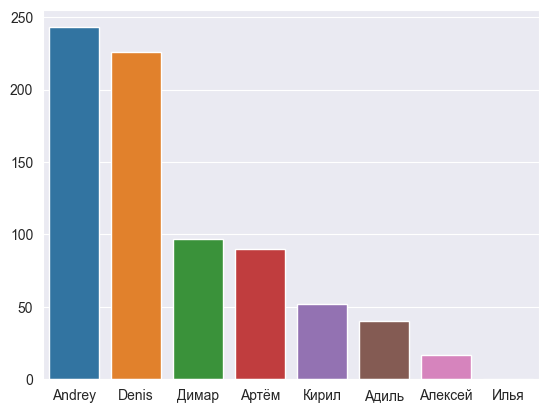

In [46]:
hist_forward = pd.DataFrame({"Andrey":[243],"Denis":[226],"Адиль":[40],"Алексей":[17],"Артём":[90],"Димар":[97],"Илья":[0],"Кирил":[52]}).T.sort_values(by=0,ascending=False)
hist_files = pd.DataFrame({"Andrey":[2496],"Denis":[1217],"Адиль":[1622],"Алексей":[372],"Артём":[2905],"Димар":[462],"Илья":[1],"Кирил":[2655]}).T.sort_values(by=0,ascending=False)
hist_text = pd.DataFrame({"Andrey":[7063],"Denis":[3883],"Адиль":[8687],"Алексей":[1250],"Артём":[11260],"Димар":[3673],"Илья":[30],"Кирил":[7891]}).T.sort_values(by=0,ascending=False)
sns.barplot(hist_forward.T)

Поиск самого длинного сообщения

In [ ]:
without_forwared = df[df["forwarded_from"].isna()].index
idx = df["text"].iloc[without_forwared].dropna().index
df["text"].iloc[idx].apply(lambda data: len(data)).max()

df.iloc[idx][df["text"].iloc[idx].apply(lambda data: len(data) == 1493)].iloc[0]

## Лаб 2

Получение длин отправленных сообщений

In [5]:
dict_hists = {}
for i in tqdm(range(56292)):
    if df.iloc[i]["text"]:
        if df.iloc[i]["from"] in dict_hists.keys():
            dict_hists[df.iloc[i]["from"]].append(len(df.iloc[i]["text"]))
        else:
            dict_hists[df.iloc[i]["from"]] = [len(df.iloc[i]["text"])]

100%|██████████| 56292/56292 [00:10<00:00, 5218.04it/s]


Исходное распределение

In [114]:
def mean(X:np.array) -> float:
    return X.sum() / X.shape[0]

def var(X:np.array,k) -> float:
    return mean((X - mean(X))**k)
    
def std(X:float):
    return np.sqrt(var(X,k=2))

def asymmetric(X:np.array,k) -> float:
    return var(X,k=k)/(std(X)**k)

def ecksces(X:np.array) -> float:
    return asymmetric(X,k=4)-3

def quantile(X:np.array,q) -> float:
    assert q < 1
    return np.sort(X)[int(X.shape[0]*q)]

x = np.array((1,2,4,5,6))
quantile(x,q=0.95)
# print(std(x),np.std(x))


np.int64(6)

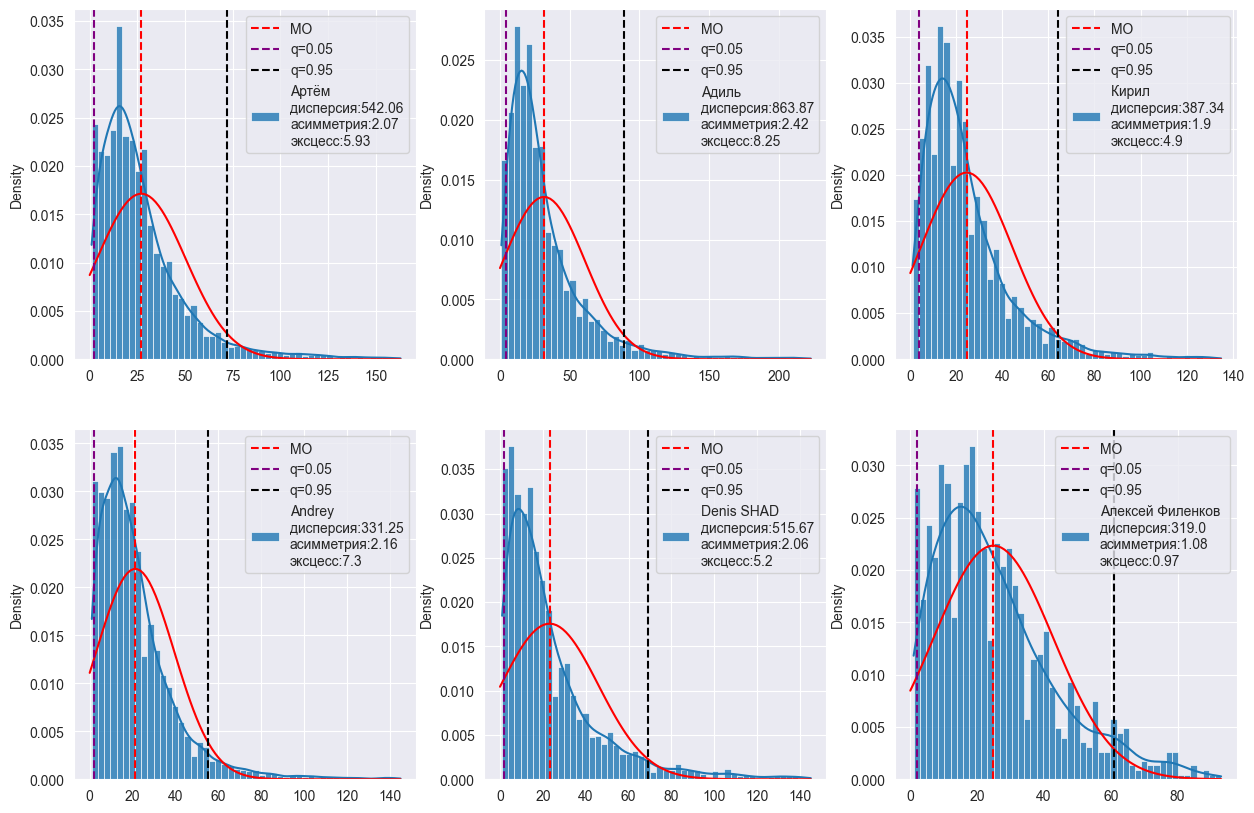

In [127]:
order = ["Артём","Адиль","Кирил","Andrey","Denis SHAD","Алексей Филенков"]
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Преобразуем подграфы в одномерный массив для удобства итерации
axs = axs.ravel()
for i, key in enumerate(order):
    item = dict_hists[key]
    item = pd.Series(item)
    # Обрезание по правилу 3 сигм
    item = item[item < mean(item)+std(item)*3]
    item = item[item > mean(item)-std(item)*3]
    ax = sns.histplot(item, ax=axs[i] ,bins = 50,kde=True, stat="density", 
                      label=key+f" \nдисперсия:{round(var(item,k=2),2)}\nасимметрия:{round(asymmetric(item,k=3),2)}\nэксцесс:{round(ecksces(item),2)}", alpha=0.8)
    # Генерируем значения для кривой нормального распределения
    x = np.linspace(0, item.max(), 100)
    y = norm.pdf(x, mean(item), std(item))

    # Рисуем нормальное распределение поверх гистограммы
    axs[i].plot(x, y, color='red', linestyle='-')
    axs[i].axvline(x=mean(item), color='red', linestyle='--', label='MO')  # Добавляем вертикальную линию
    axs[i].axvline(x=quantile(item,q=0.05), color='purple', linestyle='--', label='q=0.05')  # Добавляем вертикальную линию
    axs[i].axvline(x=quantile(item,q=0.95), color='black', linestyle='--', label='q=0.95')  # Добавляем вертикальную линию
    axs[i].legend()
    # axs[i].set_ylim(0,1000)

plt.show()

Логарифмированное распределение

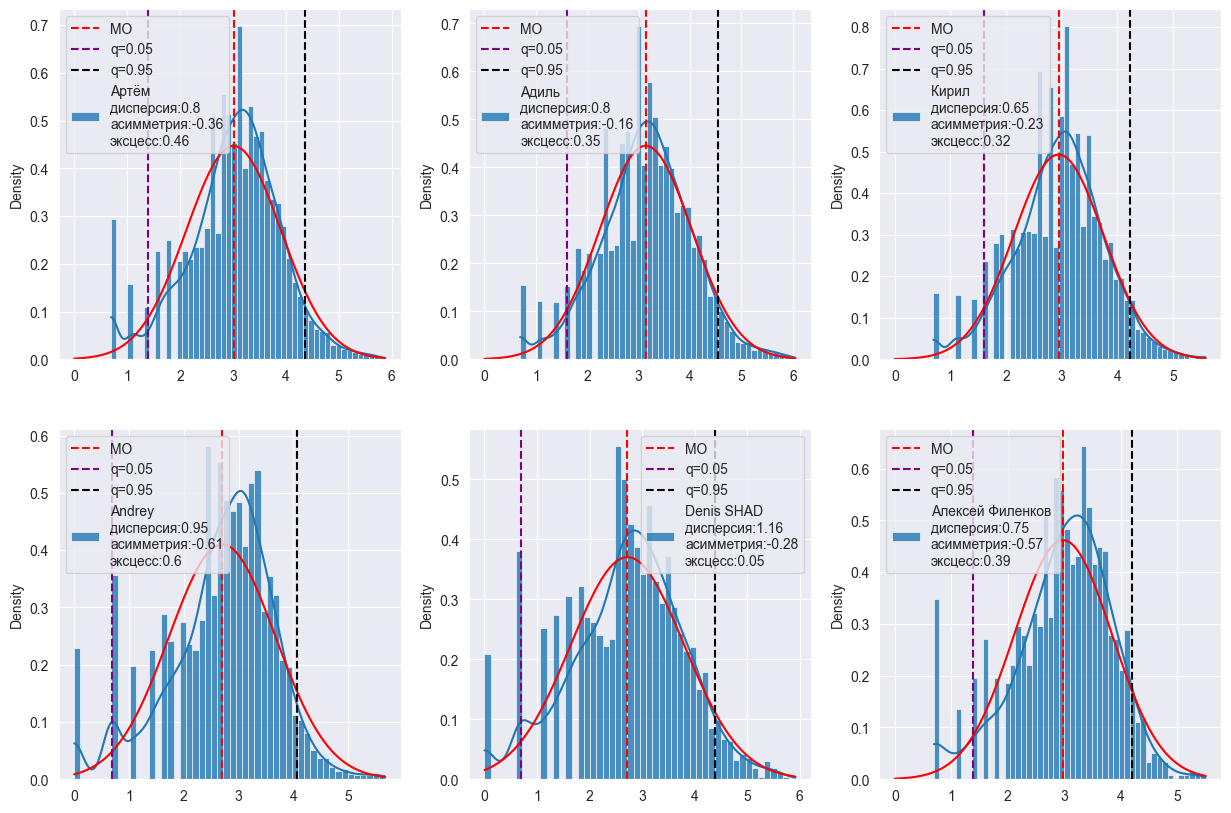

In [126]:
order = ["Артём","Адиль","Кирил","Andrey","Denis SHAD","Алексей Филенков"]
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Преобразуем подграфы в одномерный массив для удобства итерации
axs = axs.ravel()
for i, key in enumerate(order):
    item = dict_hists[key]
    item = pd.Series(item)
    item = np.log(item)
    # Обрезание по правилу 3 сигм
    item = item[item < mean(item)+std(item)*3]
    item = item[item > mean(item)-std(item)*3]

    ax = sns.histplot(item, ax=axs[i] ,bins = 50, kde=True, stat="density", 
                      label=key+f" \nдисперсия:{round(var(item,k=2),2)}\nасимметрия:{round(asymmetric(item,k=3),2)}\nэксцесс:{round(ecksces(item),2)}", alpha=0.8)
    # Генерируем значения для кривой нормального распределения
    x = np.linspace(0, item.max(), 100)
    y = norm.pdf(x, mean(item), std(item))

    # Рисуем нормальное распределение поверх гистограммы
    axs[i].plot(x, y, color='red', linestyle='-')
    axs[i].axvline(x=mean(item), color='red', linestyle='--', label='MO')  # Добавляем вертикальную линию
    axs[i].axvline(x=quantile(item,q=0.05), color='purple', linestyle='--', label='q=0.05')  # Добавляем вертикальную линию
    axs[i].axvline(x=quantile(item,q=0.95), color='black', linestyle='--', label='q=0.95')  # Добавляем вертикальную линию
    axs[i].legend()

plt.show()

## Вывод

В результате данной лабораторной работы было рассмотрено несколько распределений. Исходные распределения рукописных сообщений далеки от нормального распределения и имеют сильную положительную асимметрию и большие значения эксцессов. Тогда как логарифмированные значения этих распределений больше приближены к нормальному распределению и имеют не сильно выраженную отрицательную асимметрию и эксцесс < 3.